<a href="https://colab.research.google.com/github/Sweta-Das/Creating_Multitask_Models_Using_Keras/blob/main/Creating_Multi_task_Models_using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Multi-task Models using Keras


In [1]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil # Shutil = Shell Utilities; Higher level file operations

# Exception Handling

try:
  shutil.rmtree('logs')
except:
  pass

  shutil.rmtree() => deletes an entire directory tree; <br/>
  Syntax: shutil.rmtree(path, ignore_errors=False, onerror=None)<br/>
  <br/>
  path => points to a dir. <br/>
  If ignore_errors=True, errors due to failed removals will be ignored. If ignore_errors=False, errors are handled by handler specified<br/>
  by onerror, or if omitted, it raises an exception.

### Task - 1: Creating a dataset

In [2]:
# Using Keras Dataset to download MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# print(x_test)

We are not going to use MNIST dataset directly, we're going to synthesize new dataset from it.

In [8]:
def create_example(x, y):  # here, x= image of mnist dataset; y=label of mnist dataset
  c = np.random.randint(0, 2) # randomly assign random int either c = 0 or 1

  # Assigning colored label to mnist dataset
  image = 0.5 * np.random.rand(28, 28, 3) # for colored label, 28*28 = dim of each instance in mnist dataset & 3 signify RGB color
  image[:, :, c] += 0.5 * x / 255.  # This'll show mnist example value only for Red & Green color. The calculation will normalize the value of instance to 0 or 1.
  return image, y, c

digit: 4, color: green


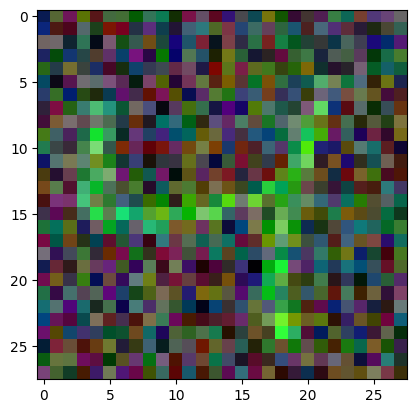

In [12]:
# Dictionary to keep track of color labels
colors = {0: 'red', 1: 'green'}

x, y, c = create_example(x_train[2], y_train[9])
print(f'digit: {y}, color: {colors[c]}') # displaying digit with its color

# Plotting image
plt.imshow(x)
plt.show()

### Task - 2: Dataset Generator

In [13]:
# For training & testing the dataset
def generate_data(x, y, batch_size= 32):

  # total number of examples = length of labels/examples
  num_examples = len(y)

  # For generator
  while True:

    # Input
    x_batch = np.zeros((batch_size, 28, 28, 3))

    # Output (0-9)
    y_batch = np.zeros((batch_size,)) # y ranges 0-9

    # Color (0 : 'red', 1 : 'Green')
    c_batch = np.zeros((batch_size,))

    # Generating examples to populate x_batch, y_batch & c_batch
    for i in range(0, batch_size):

      # Picking some random examples & passing it to create_example()
      index = np.random.randint(0, num_examples)
      image, digit, color = create_example(x[index], y[index])

      # Collecting new examples into batches
      x_batch[i] = image
      y_batch[i] = digit
      c_batch[i] = color

    # Return input, output & color
    yield x_batch, [y_batch, c_batch]

NOTE: Since, the x_batch, [y_batch, c_batch] are in tensor. The yield at the end of the program doesn't mean appended list for y_batch, & c_batch but, rather it means that y_batch in its entirety is the 1st element. And c_batch in its entirety is the 2nd one.

In [15]:
x, [y, c] = next(generate_data(x_test, y_test, batch_size= 1))

[5.] [1.]


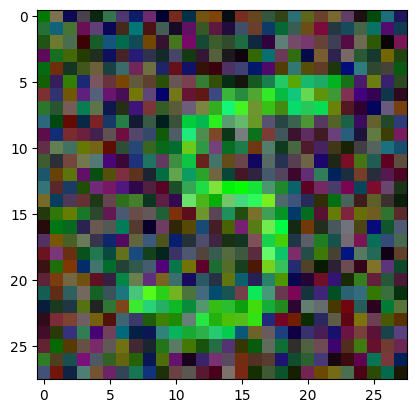

In [16]:
print(y, c)
plt.imshow(x[0]);

The output show the digit predicted and the color code for green.

### Task-3: Create Model

In [19]:
# Importing Keras layers
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense

# Creating an input tensor
input_ = Input(shape= (28, 28, 3), name= 'input')

Input Layer in Keras = 1st layer of CNN; responsible for receiving & processing the input data that will be fed to the model<br/>
<br/>
Convolution Layer = convolution means converting all the pixels in its receptive field into a single value. 2D convolution means the filter in conv. layer slides over 2D input data, performing an elementwise multiplication so that, it'll sum up the results into a single o/p pixel.<br/>
<br/>
Activation Layer (function) = It decides whether a neuron should be activated or not by calculating the weighted sum & adding bias to it. It's used to introduce non-linearity into the neuron o/p.<br/>
<br/>
Max Pooling = Used to select the max element from the region of the feature map covered by the filter
<br/>
Max Pooling 2D downsamples the i/p along its spatial dim (height & width) by taking max value over an i/p window (of size defined by pool size) for each i/p channel.<br/>
<br/>
Flatten = converting multi-dimensional data into a 1D array for sending it as an i/p to the next layer. <br/>
<br/>
Add() = adds a list of inputs. It takes a list of tensors as input, all the same shape, & returns a single tensor.<br/>
<br/>
Dense() = deeply connets the neurons in CNN i.e., every neuron in the dense layer takes i/p from all other neurons of previous layer.

1st Output of Model

In [20]:
# 1st output of model

# convolution layer-1; that takes input_ for 1st convulsion
conv_1 = Conv2D(32, 3, name= 'conv_1')(input_)

# Activation layer-1; that takes output of conv_1
act_1 = Activation('relu', name= 'act_1')(conv_1)

# Pooling Layer-1
pool_1 = MaxPool2D(4, name= 'pool_1')(act_1)

# Output of pooling layer is flattened
flat_1 = Flatten(name= 'flat_1')(pool_1)

# Dense Output layer; Collecting output of flatten to predict color
color = Dense(1, activation = 'sigmoid', name= 'color')(flat_1)

2nd output of model

In [21]:
# 2nd output of model

# Convolution layer-2; takes act_1 as input
conv_2 = Conv2D(32, 3, padding= 'same', name= 'conv_2')(act_1)

# Activation layer-2
act_2 = Activation('relu', name= 'act_2')(conv_2)

We saw in previous code that Activation layer-1 is also the input of Pooling Layer-1. It's different than being the input of Convolution Layer-2 because pooling layer is a separate branch. It branches off to predict for color in the 1st output of the model.

In [22]:
# Convolution layer-3
conv_3 = Conv2D(32, 3, padding= 'same', name= 'conv_3')(act_2)

# Adding Layers; helps to skip connections
add = Add(name = 'add')([act_1, conv_3])

# Activation layer-3
act_3 = Activation('relu', name= 'act_3')(add)

# Pooling Layer - 2
pool_2 = MaxPool2D(4, name='pool_2')(act_3)
flat_2 = Flatten(name = 'flat_2')(pool_2)

digit = Dense(10, activation= 'softmax', name= 'digit')(flat_2)

Skip Connections (Shortcut Connections) skips some of the layers in the neural network and feeds the output of one layer as the input to the next layers (Here, 1st layer o/p to 3rd layer conv). It's good for deep neural networks but, not very useful in shallow networks.

In [25]:
# Creating the model
model = tf.keras.models.Model(input_, [digit, color])

# Losses for different outputs
model.compile(
    # dictionary with keys as different outputs & values as losses of those outputs
    loss = {
      'digit': 'sparse_categorical_crossentropy',
      'color': 'binary_crossentropy'
    },
    optimizer = 'adam',
    metrics = ['accuracy']
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 26, 26, 32)   896         ['input[0][0]']                  
                                                                                                  
 act_1 (Activation)             (None, 26, 26, 32)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 26, 26, 32)   9248        ['act_1[0][0]']                  
                                                                                            

Since, we've 2 outputs (digit & color), we can use and check for different loss functions.

Plotting Model Architecture

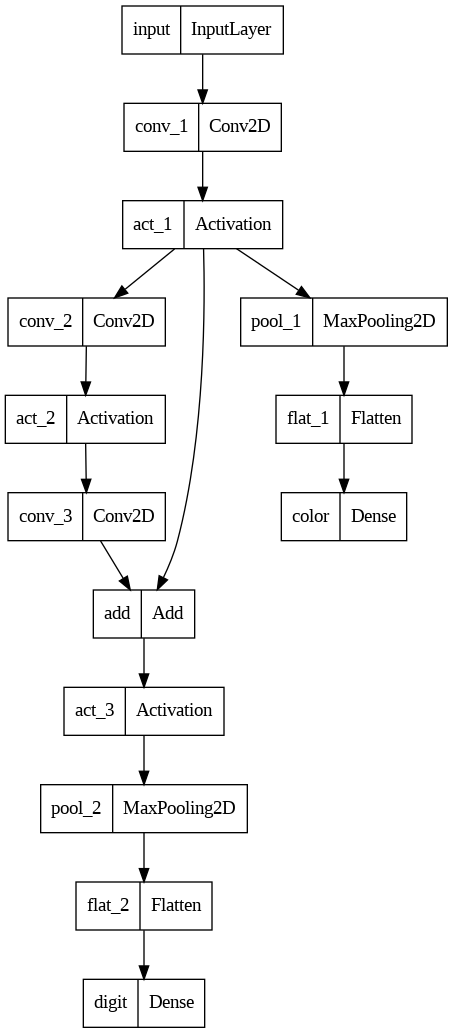

In [26]:
tf.keras.utils.plot_model(model)

Task-4: Training the Model